
Introduction

In this notebook i'll try to categorize different types of arrhytmia on ECG.

The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range. Two or more cardiologists independently annotated each record; disagreements were resolved to obtain the computer-readable reference annotations for each beat (approximately 110,000 annotations in all) included with the database.

This directory contains the entire MIT-BIH Arrhythmia Database. About half (25 of 48 complete records, and reference annotation files for all 48 records) of this database has been freely available here since PhysioNet's inception in September 1999. The 23 remaining signal files, which had been available only on the MIT-BIH Arrhythmia Database CD-ROM, were posted here in February 2005.

Much more information about this database may be found in here https://archive.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm

In this particular case the samples are a single beat that is represented in a 1D array with 187 timesteps.

In [1]:
#First we do some imports

import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
from keras.models import Sequential
from imblearn.over_sampling import SMOTE
import pywt
from keras.layers import Dense, Convolution2D, MaxPool2D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
warnings.filterwarnings('ignore')

In [2]:
#Load de data

train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

In [8]:
#Counting the amout of samples per class

train_df[187]=train_df[187].astype(int)
percents=train_df[187].value_counts()
print(percents)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [9]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


<Figure size 2160x2160 with 0 Axes>

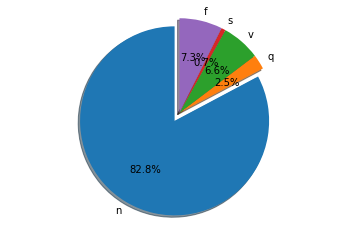

In [14]:
labels = 'n', 'q', 'v', 's','f'
sizes = [percents[0], percents[1], percents[2], percents[3],percents[4]]
explode = (0.1, 0, 0, 0,0) 
plt.figure(figsize=(30,30))
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()


In [15]:
#Here i make a dataframe out of each category and sample 20000 random samples of the largest one

df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

train_df=pd.concat([df_0,df_1,df_2,df_3,df_4])

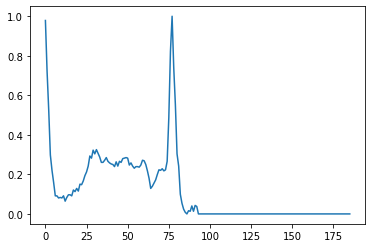

In [16]:
#A plot of a single beat

plt.plot(df_0.iloc[3,:186])

In [17]:
x_train= train_df.drop(columns=[187])
y_train=train_df[187]

In [20]:
#Here i balance the data set using the oversampling method SMOTE

smote=SMOTE({1:20000,2:20000,3:20000,4:20000})
x_train_smote , y_train_smote = smote.fit_sample(x_train,y_train)
percentSmote=y_train_smote.value_counts()
print(percentSmote)

4    20000
3    20000
2    20000
1    20000
0    20000
Name: 187, dtype: int64


<Figure size 2160x2160 with 0 Axes>

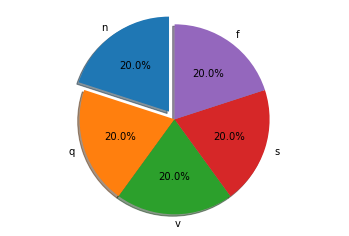

In [21]:
labels = 'n', 'q', 'v', 's','f'
sizes = [percentSmote[0], percentSmote[1], percentSmote[2], percentSmote[3],percentSmote[4]]
explode = (0.1, 0, 0, 0,0) 
plt.figure(figsize=(30,30))
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [22]:
#Here i'll plot one example of each class

df_11=x_train_smote[y_train_smote==1]
df_22=x_train_smote[y_train_smote==2]
df_33=x_train_smote[y_train_smote==3]
df_44=x_train_smote[y_train_smote==4]
df_00=x_train_smote[y_train_smote==0]

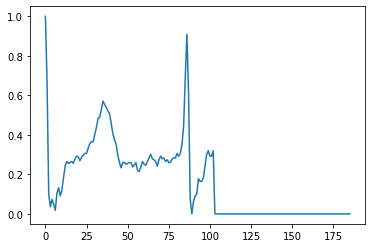

In [23]:
plt.plot(df_11.iloc[0,:186])

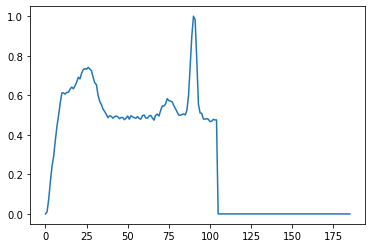

In [24]:
plt.plot(df_22.iloc[0,:186])

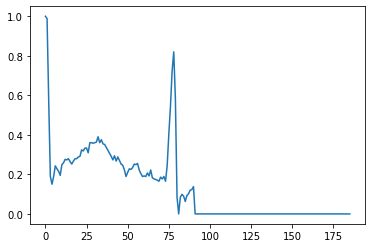

In [25]:
plt.plot(df_00.iloc[20,:186])

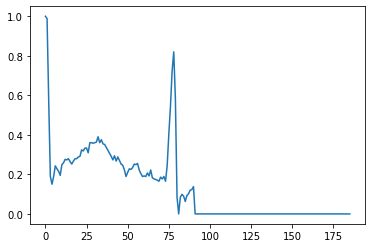

In [26]:
plt.plot(df_00.iloc[20,:186])

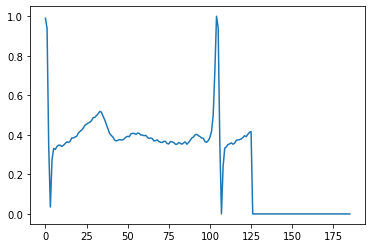

In [27]:
plt.plot(x_train_smote.iloc[1,:186])

In [28]:
#Then ill aply Continuos Wavelet Transform to each signal to get the scalogram, here is one example


scales=np.arange(1,20)
coeff1,freq1=pywt.cwt(x_train_smote.iloc[1,:186],scales,'morl')

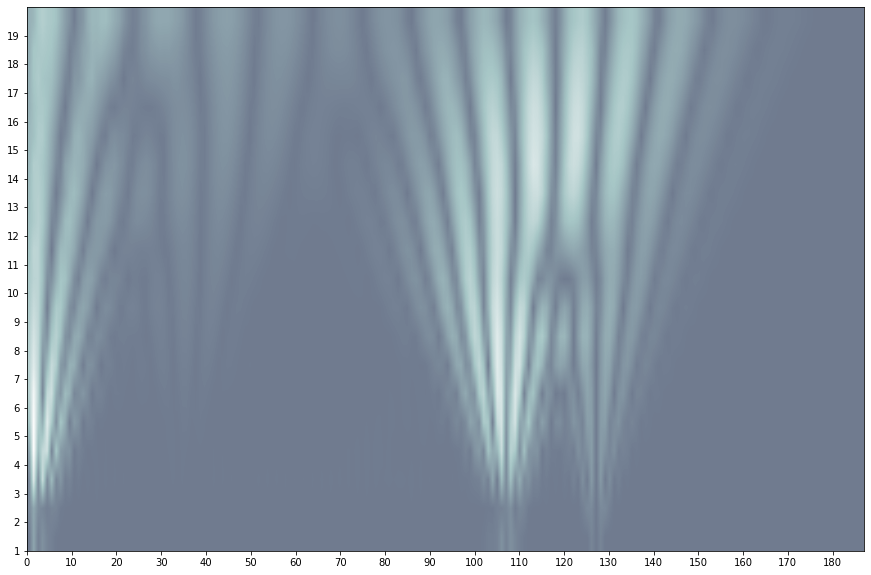

In [29]:
#Plotting the scalogram

plt.figure(figsize=(15,10))
plt.imshow(abs(coeff1),extent=[0,187,20,1],interpolation='bilinear', cmap='bone', aspect='auto',vmax=abs(coeff1).max(),vmin=-abs(coeff1).max())
plt.gca().invert_yaxis()
plt.yticks(np.arange(1,20,1))
plt.xticks(np.arange(0,187,10))
plt.show()

In [ ]:
#Now i apply the transformation to all the training data set, this took around 18hs in my computer so ill save the ndarray next


scales=np.arange(1,20)
coeffTRAIN=np.empty((19,186,1))

for ind in range (len(x_train_smote)):
    
    coeff, freqs = pywt.cwt(x_train_smote.iloc[ind][:186],scales,'morl')
    reshap=coeff.reshape(coeff.shape[0],coeff.shape[1],1)
    coeffTRAIN=np.vstack([coeffTRAIN, reshap])
   

In [ ]:
#saving the coefficients
np.save('output', coefficients)

In [ ]:
#loading them
coeffTRAIN = np.load('output.npy')

In [ ]:
#getting the right shape
separate=np.vsplit(coeffTRAIN,len(x_train_smote)+1)
coefficients=np.array(separate) 


In [30]:
X_test=test_df.iloc[:,:186].values
datatest=pd.DataFrame(X_test)


In [58]:
#same thing with the test data


scales=np.arange(1,20)
coeffTEST=np.empty((19,186,1))

for ind in range (len(datatest)):
    
    coeff, freqs = pywt.cwt(datatest.iloc[ind][:186],scales,'morl')
    reshap=coeff.reshape(coeff.shape[0],coeff.shape[1],1)
    coeffTEST=np.vstack([coeffTEST, reshap]) 

1000
5000
10000
15000
20000


In [60]:
separateTEST=np.vsplit(coeffTEST,len(datatest)+1)
coefficientsTEST=np.array(separateTEST)   

In [62]:
np.save('outputTEST', coefficientsTEST)

In [ ]:
coefficientsTEST = np.load('outputTEST.npy')

In [64]:
target_test=test_df[187]

y_train=to_categorical(y_train_smote)
y_test=to_categorical(target_test)


In [90]:
print(type(coefficients))

<class 'numpy.ndarray'>


In [94]:
coefficients = np.delete(coefficients, (10001), axis=0)

In [95]:
coefficients.shape

(100000, 19, 186, 1)

In [98]:
coefficientsTEST = np.delete(coefficientsTEST, (21892), axis=0)

In [99]:
#All shapes looks good
#there's 10000 samples each one is a "photo" 19x189 (the scalogram) and thats fed into the CNN

print(coefficients.shape)
print(coefficientsTEST.shape)
print(y_train.shape)
print(y_test.shape)

(100000, 19, 186, 1)
(21892, 19, 186, 1)
(100000, 5)
(21892, 5)


In [1]:
#Here i just define the convolutional neural network 

def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],coefficients.shape[2],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution2D(64, (6,6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool2D(pool_size=(6,6), strides=(6), padding="same")(conv1_1)
    drop1=Dropout(0.2)(pool1)
    conv2_1=Convolution2D(64, (3,3), activation='relu', input_shape=im_shape)(drop1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool2D(pool_size=(3,3), strides=(3), padding="same")(conv2_1)
    drop2=Dropout(0.2)(pool2)
    flatten=Flatten()(drop2)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=64,validation_data=(X_test,y_test))
    #model.load_weights('best_model.h5')
    return(model,history)

In [101]:
#Evaluate function

def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [102]:
#Model training

model,history=network(coefficients,y_train,coefficientsTEST,y_test)

Epoch 1/40
3125/3125 [==============================] - 397s 127ms/step - loss: 0.2853 - accuracy: 0.8989 - val_loss: 0.1793 - val_accuracy: 0.9435
Epoch 2/40
3125/3125 [==============================] - 393s 126ms/step - loss: 0.1547 - accuracy: 0.9449 - val_loss: 0.2671 - val_accuracy: 0.9033
Epoch 3/40
3125/3125 [==============================] - 395s 126ms/step - loss: 0.1186 - accuracy: 0.9581 - val_loss: 0.1696 - val_accuracy: 0.9408
Epoch 4/40
3125/3125 [==============================] - 395s 126ms/step - loss: 0.1024 - accuracy: 0.9640 - val_loss: 0.2293 - val_accuracy: 0.9184
Epoch 5/40
3125/3125 [==============================] - 398s 127ms/step - loss: 0.0916 - accuracy: 0.9682 - val_loss: 0.1718 - val_accuracy: 0.9410
Epoch 6/40
3125/3125 [==============================] - 411s 132ms/step - loss: 0.0809 - accuracy: 0.9717 - val_loss: 0.1683 - val_accuracy: 0.9434
Epoch 7/40
3125/3125 [==============================] - 401s 128ms/step - loss: 0.0741 - accuracy: 0.9740 - val_

Accuracy: 97.42%


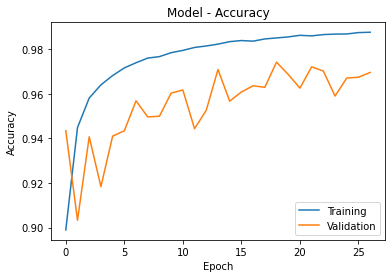

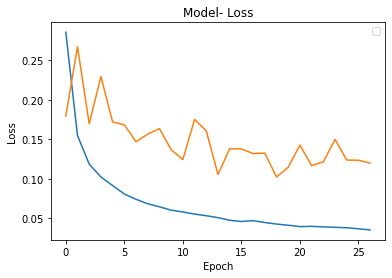

In [103]:
#Model evaluation


evaluate_model(history,coefficientsTEST,y_test,model)
y_pred=model.predict(coefficientsTEST)

Normalized confusion matrix


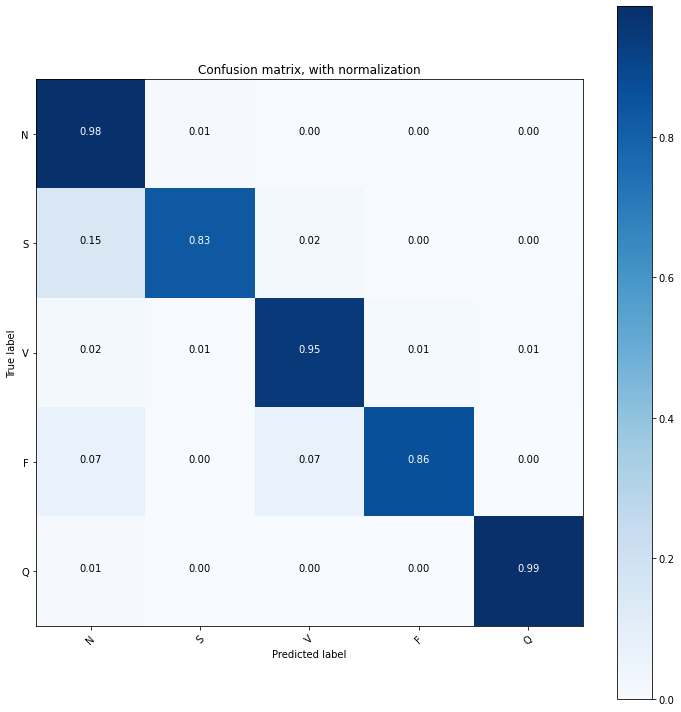

In [127]:
#Confusion matrix, i took this function from https://www.kaggle.com/coni57/model-from-arxiv-1805-00794


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()